In [ ]:
import os

# Create the data directory if it doesn't exist
if not os.path.exists("data"):
    os.makedirs("data")

# Download the dataset
!wget https://efrosgans.eecs.berkeley.edu/cyclegan/datasets/vangogh2photo.zip -P data/

# Unzip the dataset into the data directory
!unzip -q ./data/vangogh2photo.zip -d ./data/

print("Dataset downloaded and extracted to 'data/vangogh2photo'.")

# Remove the zip file after extraction to save space
!rm data/vangogh2photo.zip

Dataset downloaded and extracted to 'data/vangogh2photo'.


In [2]:
import tensorflow as tf
import keras
from keras import layers, callbacks
from typing import Tuple

In [66]:
if len(tf.config.list_physical_devices("GPU")) > 0:
    print("Tensorflow will use GPU acceleration!")

Tensorflow will use GPU acceleration!


### VGGFeatureExtractor

The `VGGFeatureExtractor` uses a **VGG19** network pre-trained on ImageNet. This network is frozen (non-trainable). Its only job is to "look" at images and extract features to calculate loss.

- **Content Layer** (`block5_conv2`): A deep layer used to capture high-level structure (shapes, objects) rather than pixel colors.
- **Style Layers** (`block1` to `block4`): Shallower layers used to capture low-level textures, brush strokes, and patterns.

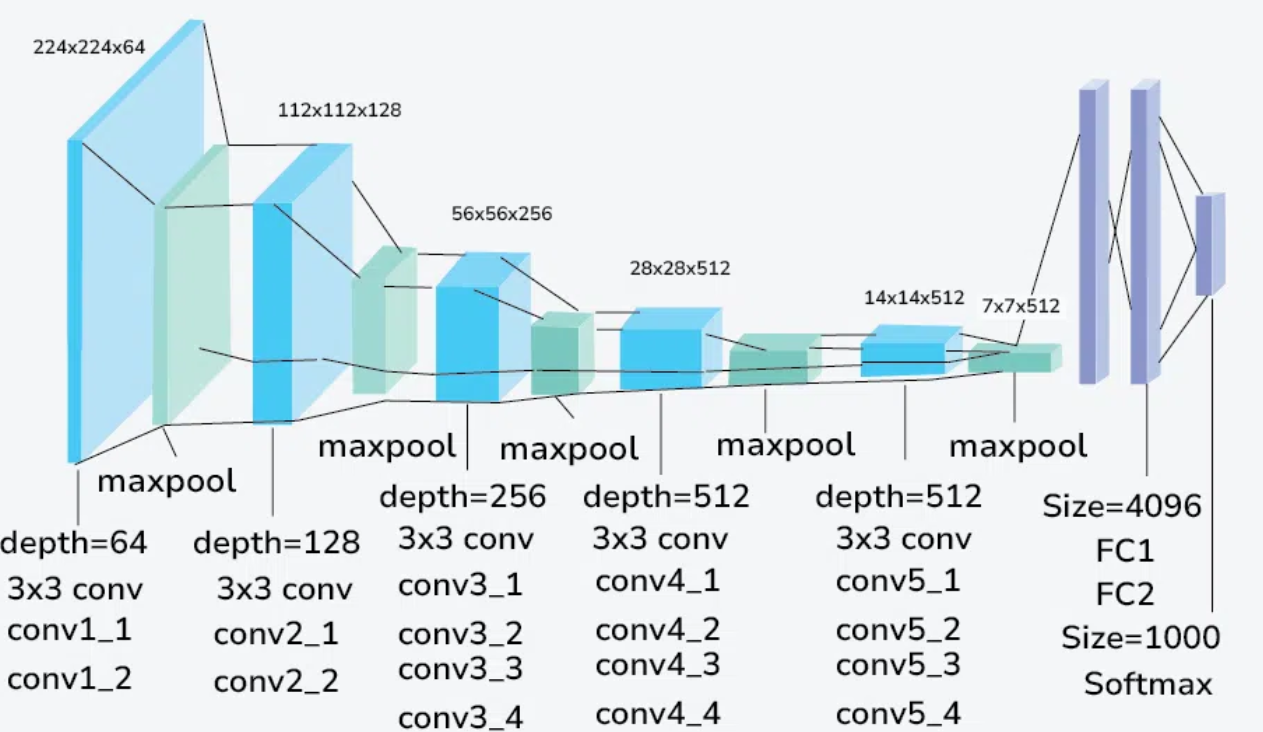

### Loss

#### Content Loss

$pred$ is the feature map of generated image and $con$ is the feature map of the content image from dataset.

$$\mathcal{L}_{\text{content}} = MSE(pred - con)$$

#### Style Loss

$$\mathcal{L}_{\text{style}} = (G_{pred} - G_{style})^2$$

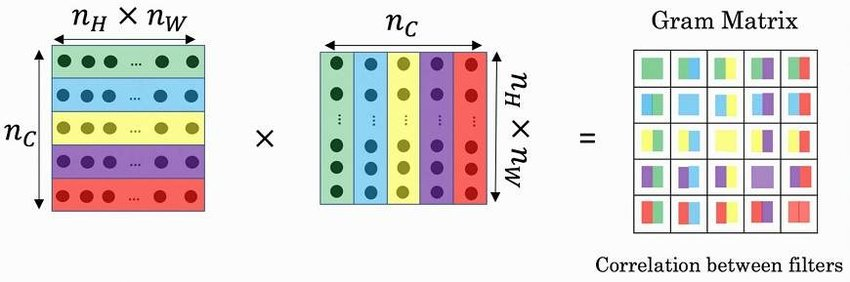

### Total Loss

$$\mathcal{L} = \alpha \cdot \mathcal{L}_{\text{content}} + \beta \cdot \mathcal{L}_{\text{style}}$$

In [135]:
class InstanceNorm(layers.Layer):
    def __init__(self, epsilon=1e-5):
        super().__init__()
        self.epsilon = epsilon

    def build(self, shape):
        channels = shape[-1]
        self.gamma = self.add_weight(shape=[channels], initializer="ones")
        self.beta = self.add_weight(shape=[channels], initializer="zeros")

    def call(self, x):
        mean, var = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        return self.gamma * (x - mean) / tf.sqrt(var + self.epsilon) + self.beta


def GeneratorNetwork(input_shape):
    inputs = keras.Input(shape=input_shape)

    # Conv block
    x = layers.Conv2D(32, 9, strides=1, padding="same")(inputs)
    x = InstanceNorm()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(64, 3, strides=2, padding="same")(x)
    x = InstanceNorm()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = InstanceNorm()(x)
    x = layers.ReLU()(x)

    # Residual blocks
    def residual_block(t):
        y = layers.Conv2D(128, 3, padding="same")(t)
        y = InstanceNorm()(y)
        y = layers.ReLU()(y)
        y = layers.Conv2D(128, 3, padding="same")(y)
        y = InstanceNorm()(y)
        return layers.add([t, y])

    for _ in range(5):
        x = residual_block(x)

    # Deconv block
    x = layers.Conv2DTranspose(64, 3, strides=2, padding="same")(x)
    x = InstanceNorm()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2DTranspose(32, 3, strides=2, padding="same")(x)
    x = InstanceNorm()(x)
    x = layers.ReLU()(x)

    outputs = layers.Conv2D(3, 9, activation="tanh", padding="same")(x)

    outputs = (outputs + 1) / 2.0

    return keras.Model(inputs=inputs, outputs=outputs, name="generator")


def preprocess(image):
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = keras.applications.vgg19.preprocess_input(image * 255.0)
    return image


def gram_matrix(tensor):
    batch, h, w, c = tf.unstack(tf.shape(tensor))
    features = tf.reshape(tensor, [batch, h * w, c])
    gram = tf.matmul(features, features, transpose_a=True)
    return gram / tf.cast(h * w, tf.float32)


def VGGFeatureExtractor():
    vgg = keras.applications.VGG19(include_top=False, weights="imagenet")
    vgg.trainable = False

    content_layer = "block5_conv2"
    style_layers = ["block1_conv1", "block2_conv1", "block3_conv1", "block4_conv1"]

    outputs = [vgg.get_layer(name).output for name in (style_layers + [content_layer])]

    return keras.Model(inputs=vgg.input, outputs=outputs, name="vgg_extractor")


class StyleTransfer(keras.Model):
    def __init__(
        self,
        input_shape: Tuple,
        style_image: tf.Tensor,
        alpha: float = 1e4,
        beta: float = 1e-2,
    ):
        super().__init__()

        self.alpha = tf.constant(alpha, dtype=tf.float32)
        self.beta = tf.constant(beta, dtype=tf.float32)

        # Generator is now the trainable part of the model
        self.generator = GeneratorNetwork(input_shape)
        self.vgg_feature_extractor = VGGFeatureExtractor()

        # Pre-compute fixed style targets (Gram matrices of the style image)
        self.num_style_layers = 4
        preprocessed_style = preprocess(style_image)

        style_features = self.vgg_feature_extractor(preprocessed_style)
        self.style_targets = [
            gram_matrix(f) for f in style_features[: self.num_style_layers]
        ]

        self.content_loss_fn = lambda g, t: tf.reduce_mean(tf.square(g - t))

    def compile(self, optimizer, loss=None, metrics=None, loss_weights=None, **kwargs):
        super().compile(optimizer=optimizer, metrics=metrics, **kwargs)

    @tf.function
    def compute_loss(self, content_image: tf.Tensor) -> tf.Tensor:
        # 1. Generate the stylized image
        # Note: Generator outputs image in [0, 1] range.
        generated_image = self.generator(content_image)

        # 2. Preprocess images for VGG (0-255, BGR, centered)
        p_content = preprocess(content_image)
        p_generated = preprocess(generated_image)

        # 3. Extract features
        content_features = self.vgg_feature_extractor(p_content)
        generated_features = self.vgg_feature_extractor(p_generated)

        # Separate features into style and content lists
        # VGG output order: [style_1, style_2, style_3, style_4, content_5]

        content_target = content_features[self.num_style_layers]
        generated_content = generated_features[self.num_style_layers]
        c_loss = self.content_loss_fn(generated_content, content_target)

        style_outputs = [
            gram_matrix(f) for f in generated_features[: self.num_style_layers]
        ]

        s_loss = tf.constant(0.0, dtype=tf.float32)

        for output, target in zip(style_outputs, self.style_targets):
            s_loss += tf.reduce_mean(tf.square(output - target))

        s_loss = s_loss / float(self.num_style_layers)

        total_loss = (self.alpha * c_loss) + (self.beta * s_loss)
        return total_loss, generated_image

    @tf.function
    def train_step(self, data):
        content_image = data

        with tf.GradientTape() as tape:
            total_loss, generated_image = self.compute_loss(content_image)

        trainable_vars = self.generator.trainable_variables
        gradients = tape.gradient(total_loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        return {"loss": total_loss}

    @tf.function
    def call(self, inputs):
        return self.generator(inputs)


In [136]:
import tensorflow as tf
import os

IMG_SIZE = 256
BATCH_SIZE = 4


def load_and_preprocess(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    return img


def make_dataset(dir_path):
    files = tf.data.Dataset.list_files(os.path.join(dir_path, "*"), shuffle=True)
    return files.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)


# --- TRAIN ---
train_content_ds = make_dataset("data/vangogh2photo/trainB")
train_ds = train_content_ds.shuffle(500).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# --- TEST ---
test_content_ds = make_dataset("data/vangogh2photo/testB")
test_ds = test_content_ds.shuffle(500).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


style_image_path = "data/van_gogh_style.jpg"

style_image = load_and_preprocess(style_image_path)
style_image = tf.expand_dims(style_image, axis=0)

print("Dataset paths have been updated to local directories.")

Dataset paths have been updated to local directories.


In [141]:
model = StyleTransfer(
    input_shape=(IMG_SIZE, IMG_SIZE) + (3,),
    style_image=style_image,
    alpha=1e4,
    beta=1e-3,
)

In [142]:
# # 2. Compile (now using Keras Model's native compile/fit API)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3))


In [143]:
keras.utils.register_keras_serializable()(GeneratorNetwork)
keras.utils.register_keras_serializable()(VGGFeatureExtractor)
keras.utils.register_keras_serializable()(StyleTransfer)

checkpoint_dir = "checkpoints"
ckpt = tf.train.Checkpoint(generator=model.generator, optimizer=model.optimizer)
manager = tf.train.CheckpointManager(ckpt, checkpoint_dir, max_to_keep=5)

In [144]:
checkpoint_filepath = "./checkpoints/style_transfer_model_weights.weights.h5"
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=1,
)

history = model.fit(train_ds, epochs=1)

save_path = manager.save()
print("Model saved", save_path)

953/953 ━━━━━━━━━━━━━━━━━━━━ 2610s 2s/step - loss: 0.0000e+00
Model saved checkpoints/ckpt-1


In [20]:
ckpt = tf.train.Checkpoint(generator=model.generator)
ckpt.restore(manager.latest_checkpoint).expect_partial()

## Image Stylization comparison

After 1 epoch.

$\alpha$ content preservation factor
$\beta$ style preservation factor

### $\alpha = 1\mathrm{e}{5}, \beta = 1\mathrm{e}{2}$

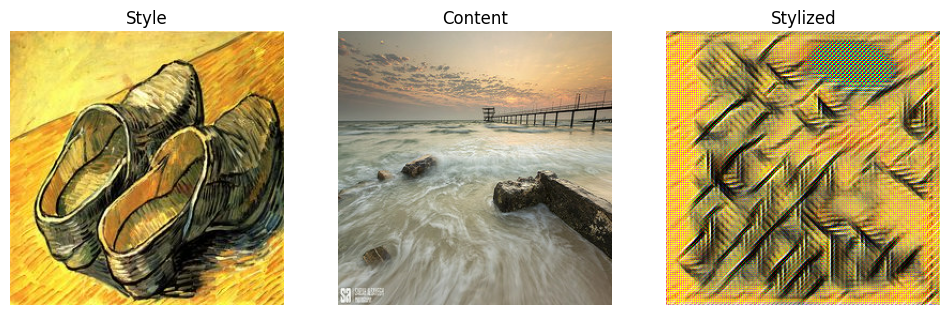

### $\alpha = 1\mathrm{e}{4}, \beta = 1\mathrm{e}{-2}$

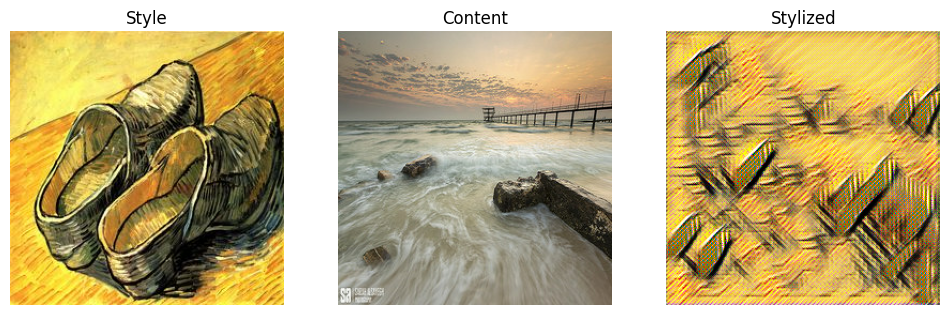

### $\alpha = 1\mathrm{e}{4}, \beta = 1\mathrm{e}{-3}$

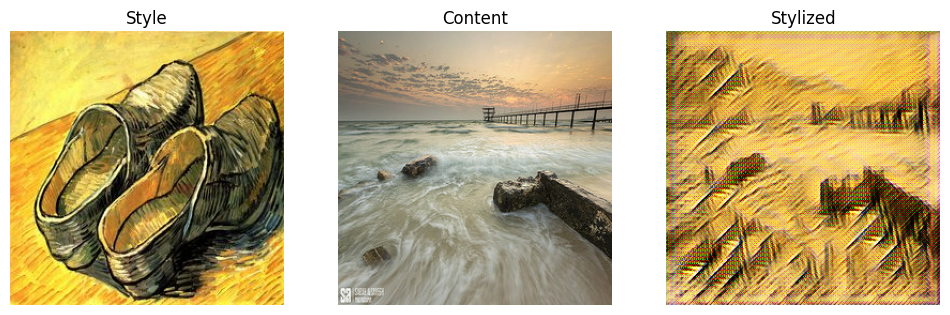

### $\alpha = 1\mathrm{e}{4}, \beta = 1\mathrm{e}{-4}$

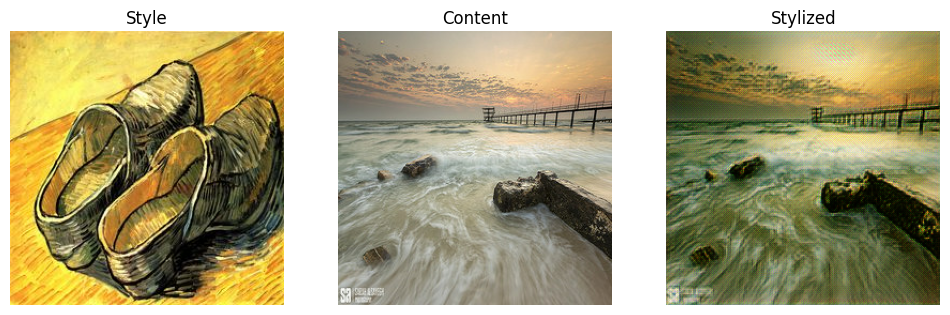

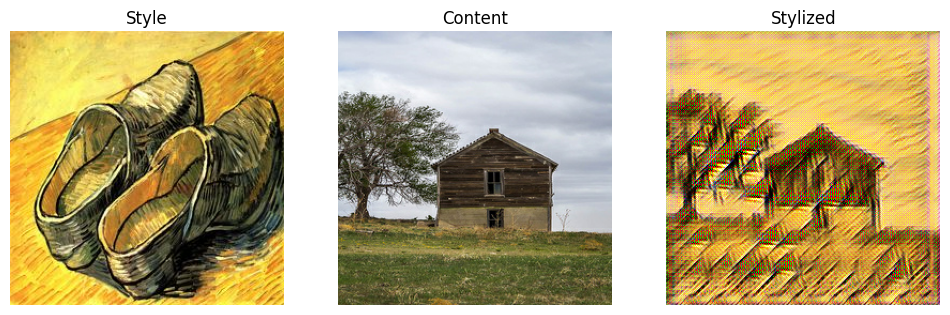

In [165]:
import matplotlib.pyplot as plt

img = next(iter(test_ds.unbatch()))
input_img = tf.reshape(img, (1, IMG_SIZE, IMG_SIZE, 3))
styled = model(input_img)


plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(tf.reshape(style_image, (IMG_SIZE, IMG_SIZE, 3)).numpy())
plt.title("Style")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(img)
plt.title("Content")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(tf.reshape(styled, (IMG_SIZE, IMG_SIZE, 3)).numpy())
plt.title("Stylized")
plt.axis("off")

plt.show()